```
Topic:        Project 1
Subject:      Explore MTA turnstile data
Date:         07/06/2020
Names:        David Weon, Adam Rauckhorst, Dyllan Usher

Notebook has been cleaned using nbextension 'Code prettify'
```

# Analyzing MTA Data by Time of Day

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline
sns.set(style='white', palette='colorblind')

In [2]:
# Reading in the data


def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week in dates:
        file_url = url.format(week)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)


dates = [190601, 190608, 190615, 190622, 190525, 190518]
df = get_data(dates)

In [3]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7071830,2396411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,04:00:00,REGULAR,7071844,2396415
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,08:00:00,REGULAR,7071864,2396443
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,12:00:00,REGULAR,7071943,2396500
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,16:00:00,REGULAR,7072182,2396555


In [4]:
# Removing all but the top stations that we want to focus on

stations = [
    '34 ST-PENN STA', '34 ST-HERALD SQ', '23 ST', '42 ST-PORT AUTH',
    'TIMES SQ-42 ST', '59 ST', 'ATL AV-BARCLAY', 'JAY ST-METROTEC',
    'CHURCH AV', 'BOROUGH HALL'
]

df = df[df['STATION'].isin(stations)]

In [5]:
# Checking to make sure I'm only looking at those ten stations

df['STATION'].unique()

array(['59 ST', 'TIMES SQ-42 ST', '34 ST-HERALD SQ', '23 ST', 'CHURCH AV',
       'BOROUGH HALL', 'JAY ST-METROTEC', 'ATL AV-BARCLAY',
       '42 ST-PORT AUTH', '34 ST-PENN STA'], dtype=object)

In [6]:
# Checking for duplicates

(df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE",
             "TIME"]).ENTRIES.count().reset_index().sort_values(
                 "ENTRIES", ascending=False).head(20))

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,05/11/2019,00:00:00,1
90153,R142,R293,01-00-00,34 ST-PENN STA,05/24/2019,06:00:00,1
90167,R142,R293,01-00-00,34 ST-PENN STA,05/26/2019,14:00:00,1
90166,R142,R293,01-00-00,34 ST-PENN STA,05/26/2019,10:00:00,1
90165,R142,R293,01-00-00,34 ST-PENN STA,05/26/2019,06:00:00,1
90164,R142,R293,01-00-00,34 ST-PENN STA,05/26/2019,02:00:00,1
90163,R142,R293,01-00-00,34 ST-PENN STA,05/25/2019,22:00:00,1
90162,R142,R293,01-00-00,34 ST-PENN STA,05/25/2019,18:00:00,1
90161,R142,R293,01-00-00,34 ST-PENN STA,05/25/2019,14:00:00,1
90160,R142,R293,01-00-00,34 ST-PENN STA,05/25/2019,10:00:00,1


In [7]:
# Checking to see if we have any odd times in the data

df['TIME'].unique()[0:20]

array(['00:00:00', '04:00:00', '08:00:00', '12:00:00', '16:00:00',
       '20:00:00', '07:19:56', '02:00:00', '06:00:00', '10:00:00',
       '14:00:00', '18:00:00', '22:00:00', '08:08:27', '01:00:00',
       '05:00:00', '09:00:00', '13:00:00', '17:00:00', '21:00:00'],
      dtype=object)

In [8]:
def round_hour(time):
    """This function takes a time in hh:mm:ss format and rounds to the nearest 
    four hour interval (00:00, 04:00, etc.).
    
    Arg: time <str> takes in a string in a time format of hh:mm:ss
    Return: <str> in the format of hh:00 where hh ranges from 00 to 24 in intervals of 4
    
    """
    time = int(time[0:2])
    if time % 4 == 1:
        time -= 1
    elif time % 4 == 2:
        time -= 2
    elif time % 4 == 3:
        time += 1

    if time < 9:
        return '0' + str(time) + ':00'
    else:
        return str(time) + ':00'

In [9]:
# Making a copy of the dataframe to manipulate

df2 = df.copy()
df2['TIME']

0         00:00:00
1         04:00:00
2         08:00:00
3         12:00:00
4         16:00:00
            ...   
204601    05:00:00
204602    09:00:00
204603    13:00:00
204604    17:00:00
204605    21:00:00
Name: TIME, Length: 135236, dtype: object

In [10]:
# Applying the round_hour function to the ['TIME'] column

df2['TIME'] = df2['TIME'].apply(round_hour)

In [11]:
# Confirming unique values

df2['TIME'].unique()

array(['00:00', '04:00', '08:00', '12:00', '16:00', '20:00'], dtype=object)

In [12]:
df2

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00,REGULAR,7071830,2396411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,04:00,REGULAR,7071844,2396415
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,08:00,REGULAR,7071864,2396443
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,12:00,REGULAR,7071943,2396500
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,16:00,REGULAR,7072182,2396555
...,...,...,...,...,...,...,...,...,...,...,...
204601,R639,R109,00-06-00,CHURCH AV,25,IRT,05/17/2019,04:00,REGULAR,856080099,1577595229
204602,R639,R109,00-06-00,CHURCH AV,25,IRT,05/17/2019,08:00,REGULAR,856080282,1577595399
204603,R639,R109,00-06-00,CHURCH AV,25,IRT,05/17/2019,12:00,REGULAR,856080502,1577595558
204604,R639,R109,00-06-00,CHURCH AV,25,IRT,05/17/2019,16:00,REGULAR,856080768,1577595835


In [13]:
# Drop columns that are not needed

df2 = df2.drop(['EXITS', 'DESC', 'DIVISION', 'LINENAME'],
               axis=1,
               errors='ignore')

In [14]:
df2

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,05/25/2019,00:00,7071830,2396411
1,A002,R051,02-00-00,59 ST,05/25/2019,04:00,7071844,2396415
2,A002,R051,02-00-00,59 ST,05/25/2019,08:00,7071864,2396443
3,A002,R051,02-00-00,59 ST,05/25/2019,12:00,7071943,2396500
4,A002,R051,02-00-00,59 ST,05/25/2019,16:00,7072182,2396555
...,...,...,...,...,...,...,...,...
204601,R639,R109,00-06-00,CHURCH AV,05/17/2019,04:00,856080099,1577595229
204602,R639,R109,00-06-00,CHURCH AV,05/17/2019,08:00,856080282,1577595399
204603,R639,R109,00-06-00,CHURCH AV,05/17/2019,12:00,856080502,1577595558
204604,R639,R109,00-06-00,CHURCH AV,05/17/2019,16:00,856080768,1577595835


In [15]:
# Adding day of week to the dataframe

df2['DATE'] = pd.to_datetime(df2['DATE'])
df2['DAY'] = df2['DATE'].dt.day_name()
df2['DAY'].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [16]:
df2

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DAY
0,A002,R051,02-00-00,59 ST,2019-05-25,00:00,7071830,2396411,Saturday
1,A002,R051,02-00-00,59 ST,2019-05-25,04:00,7071844,2396415,Saturday
2,A002,R051,02-00-00,59 ST,2019-05-25,08:00,7071864,2396443,Saturday
3,A002,R051,02-00-00,59 ST,2019-05-25,12:00,7071943,2396500,Saturday
4,A002,R051,02-00-00,59 ST,2019-05-25,16:00,7072182,2396555,Saturday
...,...,...,...,...,...,...,...,...,...
204601,R639,R109,00-06-00,CHURCH AV,2019-05-17,04:00,856080099,1577595229,Friday
204602,R639,R109,00-06-00,CHURCH AV,2019-05-17,08:00,856080282,1577595399,Friday
204603,R639,R109,00-06-00,CHURCH AV,2019-05-17,12:00,856080502,1577595558,Friday
204604,R639,R109,00-06-00,CHURCH AV,2019-05-17,16:00,856080768,1577595835,Friday


In [17]:
# Segmenting the turnstiles

hourly_data = (df2.groupby(
    ["C/A", "UNIT", "SCP", "STATION", "DATE", "DAY", "TIME"],
    as_index=False).ENTRIES.first())

hourly_data.sort_values(['STATION', 'DATE'], inplace=True)
hourly_data.head(25)

,C/A,UNIT,SCP,STATION,DATE,DAY,TIME,ENTRIES
8784,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,00:00,53427
8785,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,04:00,53432
8786,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,08:00,53432
8787,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,12:00,53436
8788,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,16:00,53445
8789,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,20:00,53530
9036,A030,R083,01-00-01,23 ST,2019-05-11,Saturday,00:00,6848331
9037,A030,R083,01-00-01,23 ST,2019-05-11,Saturday,04:00,6848393
9038,A030,R083,01-00-01,23 ST,2019-05-11,Saturday,08:00,6848413
9039,A030,R083,01-00-01,23 ST,2019-05-11,Saturday,12:00,6848568


In [18]:
# Adding the column ['PREV_ENTRIES'] to calculate net entries

hourly_data["PREV_ENTRIES"] = (hourly_data.groupby(
    ["C/A", "UNIT", "SCP",
     "STATION"])["ENTRIES"].apply(lambda grp: grp.shift(1)))

In [19]:
hourly_data.head(25)

,C/A,UNIT,SCP,STATION,DATE,DAY,TIME,ENTRIES,PREV_ENTRIES
8784,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,00:00,53427,NaN
8785,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,04:00,53432,53427.0
8786,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,08:00,53432,53432.0
8787,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,12:00,53436,53432.0
8788,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,16:00,53445,53436.0
8789,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,20:00,53530,53445.0
9036,A030,R083,01-00-01,23 ST,2019-05-11,Saturday,00:00,6848331,NaN
9037,A030,R083,01-00-01,23 ST,2019-05-11,Saturday,04:00,6848393,6848331.0
9038,A030,R083,01-00-01,23 ST,2019-05-11,Saturday,08:00,6848413,6848393.0
9039,A030,R083,01-00-01,23 ST,2019-05-11,Saturday,12:00,6848568,6848413.0


In [20]:
# Setting the value for ['PREV_ENTRIES'] to ['ENTRIES'] for all midnight instances to start at zero

hourly_data['PREV_ENTRIES'] = hourly_data.apply(
    lambda row: row['ENTRIES']
    if np.isnan(row['PREV_ENTRIES']) else row['PREV_ENTRIES'],
    axis=1)

In [21]:
hourly_data['PREV_ENTRIES'] = hourly_data['PREV_ENTRIES'].astype(int)
hourly_data

,C/A,UNIT,SCP,STATION,DATE,DAY,TIME,ENTRIES,PREV_ENTRIES
8784,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,00:00,53427,53427
8785,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,04:00,53432,53427
8786,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,08:00,53432,53432
8787,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,12:00,53436,53432
8788,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,16:00,53445,53436
...,...,...,...,...,...,...,...,...,...
100713,R151,R033,00-00-08,TIMES SQ-42 ST,2019-06-21,Friday,04:00,8088876,8088731
100714,R151,R033,00-00-08,TIMES SQ-42 ST,2019-06-21,Friday,08:00,8089335,8088876
100715,R151,R033,00-00-08,TIMES SQ-42 ST,2019-06-21,Friday,12:00,8089993,8089335
100716,R151,R033,00-00-08,TIMES SQ-42 ST,2019-06-21,Friday,16:00,8090598,8089993


In [22]:
def get_hourly_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0?
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [23]:
hourly_data["HOURLY_ENTRIES"] = hourly_data.apply(get_hourly_counts, axis=1, max_counter=100000)
hourly_data

12 138747
458856 4526857
209 201981
5570789 104608160
16 13967417
146 36966559


,C/A,UNIT,SCP,STATION,DATE,DAY,TIME,ENTRIES,PREV_ENTRIES,HOURLY_ENTRIES
8784,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,00:00,53427,53427,0
8785,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,04:00,53432,53427,5
8786,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,08:00,53432,53432,0
8787,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,12:00,53436,53432,4
8788,A030,R083,01-00-00,23 ST,2019-05-11,Saturday,16:00,53445,53436,9
...,...,...,...,...,...,...,...,...,...,...
100713,R151,R033,00-00-08,TIMES SQ-42 ST,2019-06-21,Friday,04:00,8088876,8088731,145
100714,R151,R033,00-00-08,TIMES SQ-42 ST,2019-06-21,Friday,08:00,8089335,8088876,459
100715,R151,R033,00-00-08,TIMES SQ-42 ST,2019-06-21,Friday,12:00,8089993,8089335,658
100716,R151,R033,00-00-08,TIMES SQ-42 ST,2019-06-21,Friday,16:00,8090598,8089993,605


In [24]:
hourly_data.describe(percentiles=[.5, .75, .8, .9, .95, .96, .97, .98, .99])

,ENTRIES,PREV_ENTRIES,HOURLY_ENTRIES
count,1.324150e+05,1.324150e+05,132415.000000
mean,6.538480e+07,6.538575e+07,233.814356
std,2.783947e+08,2.783946e+08,430.720464
min,0.000000e+00,0.000000e+00,0.000000
50%,3.899458e+06,3.899524e+06,121.000000
75%,9.256080e+06,9.256174e+06,324.000000
80%,1.134313e+07,1.134331e+07,393.000000
90%,5.033438e+07,5.033438e+07,612.000000
95%,1.342181e+08,1.342181e+08,842.000000
96%,4.139215e+08,4.139220e+08,929.000000


In [25]:
# Looking to eliminate the outliers

hourly_data[hourly_data['HOURLY_ENTRIES'] > 5000]

,C/A,UNIT,SCP,STATION,DATE,DAY,TIME,ENTRIES,PREV_ENTRIES,HOURLY_ENTRIES
104007,R227,R131,00-00-01,23 ST,2019-05-14,Tuesday,16:00,89699,113260,23561
104258,R227,R131,00-00-02,23 ST,2019-05-14,Tuesday,16:00,113793,89159,24634
104504,R227,R131,00-00-03,23 ST,2019-05-14,Tuesday,08:00,10,78423,78413
22054,C021,R212,00-00-00,59 ST,2019-06-13,Thursday,12:00,8975399,8968425,6974
123097,R610,R057,00-04-01,ATL AV-BARCLAY,2019-06-21,Friday,12:00,125,28711,28586
100251,R151,R033,00-00-07,TIMES SQ-42 ST,2019-05-17,Friday,00:00,594,23719,23125
99912,R151,R033,00-00-05,TIMES SQ-42 ST,2019-06-12,Wednesday,08:00,54,60776,60722


In [26]:
# Dropping the outliers as there are only 7 rows

hourly_data = hourly_data[hourly_data['HOURLY_ENTRIES'] < 5000]

In [27]:
entries_per_hour = hourly_data.groupby(['STATION', 'DAY',
                                        'TIME'])['HOURLY_ENTRIES'].sum()

In [28]:
entries_per_hour = entries_per_hour.reset_index()
entries_per_hour

,STATION,DAY,TIME,HOURLY_ENTRIES
0,23 ST,Friday,00:00,98610
1,23 ST,Friday,04:00,9402
2,23 ST,Friday,08:00,40587
3,23 ST,Friday,12:00,118598
4,23 ST,Friday,16:00,185959
...,...,...,...,...
415,TIMES SQ-42 ST,Wednesday,04:00,19001
416,TIMES SQ-42 ST,Wednesday,08:00,35878
417,TIMES SQ-42 ST,Wednesday,12:00,86521
418,TIMES SQ-42 ST,Wednesday,16:00,108266


In [29]:
# Taking out the weekend days

entries_per_hour = entries_per_hour[entries_per_hour['DAY'].isin(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

In [30]:
entries_per_hour['DAY'].unique()

array(['Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype=object)

---

## This answers the question, what time of day?

In [31]:
manhattan_data = entries_per_hour[entries_per_hour.STATION.isin(stations[0:5])]
brooklyn_data = entries_per_hour[entries_per_hour.STATION.isin(stations[5::])]

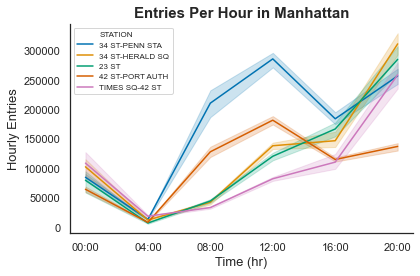

In [41]:
#Manhattan Time Series
# 1. 34 ST-PENN STA
# 2. 34 ST-HERALD SQ
# 3. 23 ST
# 4. 42 ST-PORT AUTH
# 5. TIMES SQ-42 ST

sns.lineplot(x='TIME',
             y='HOURLY_ENTRIES',
             data=manhattan_data,
             hue='STATION',
             hue_order=[
                 "34 ST-PENN STA", "34 ST-HERALD SQ", "23 ST",
                 '42 ST-PORT AUTH', 'TIMES SQ-42 ST'
             ])
plt.legend(loc='upper left', prop={'size': 8}, fancybox=True)
plt.xlabel('Time (hr)', size=13)
plt.ylabel('Hourly Entries', size=13)
plt.title("Entries Per Hour in Manhattan", fontsize=15, weight='bold')
sns.despine()
plt.tight_layout()
plt.savefig("Manhattan_Hourly.png", dpi=600)

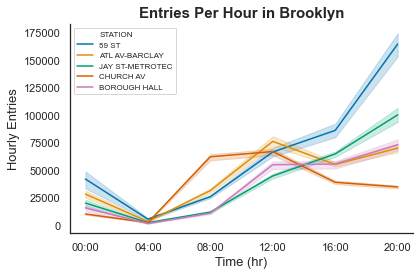

In [42]:
#Brooklyn Time Series
# 1. 59 ST
# 2. ATL AV-BARCLAY
# 3. JAY ST-METROTEC
# 4. CHURCH AV
# 5. BOROUGH HALL

sns.lineplot(x='TIME',
             y='HOURLY_ENTRIES',
             data=brooklyn_data,
             hue='STATION',
             hue_order=[
                 '59 ST', 'ATL AV-BARCLAY', 'JAY ST-METROTEC', 'CHURCH AV',
                 'BOROUGH HALL'
             ])
plt.legend(loc='upper left', prop={'size': 8}, fancybox=True)
plt.xlabel('Time (hr)', size=13)
plt.ylabel('Hourly Entries', size=13)
plt.title("Entries Per Hour in Brooklyn", fontsize=15, weight='bold')
sns.despine()
plt.tight_layout()
plt.savefig('Brookyln_Hourly.png', dpi=600)

In [34]:
#I wanna try to use a polynomial regression to fit the points better in the future

---